In [1]:
import numpy as np
import matplotlib.pyplot as plt
import helpers.cusplot as cplt

## constants (SI)

In [2]:
## general
rho = 0.018 # spec. res. of Cu [Ohm*mm2/m]
A = 25 # Conductor c.s. [mm2]
cdens = 10 # max. current density [A/mm2] 

## kicker
brho = 1.23 
lgap = 0.11
hap = 0.25 # horizontal aperture (pole width)
kick_l = 0.5
N = 20
u0 = 4*np.pi*1e-7

thet_kick = 0.02
l = 3 # dist. kicker-septum

B = brho*thet_kick/kick_l + 0.01 # puffer B-field 10 mT
NI = B/u0*lgap

l_wind = 2*kick_l + 2*hap # len. of winding

## charge distribution
sigma = 0.015
delta_x_max = 0.01

## septum
w = 0.005 # 5 mm thickness for DC septum (CERN paper)
# assuming infinte extend in y (valid - 100 mm beam tube > 6 sigma)

In [3]:
# conv. turns to current (display if j > 10 A/mm2)
def N_to_I(N):
    if N != 0:
        I = NI/N
    else:
        I = NI
    return round(I,2)

### inductance (N turns) / Time constant

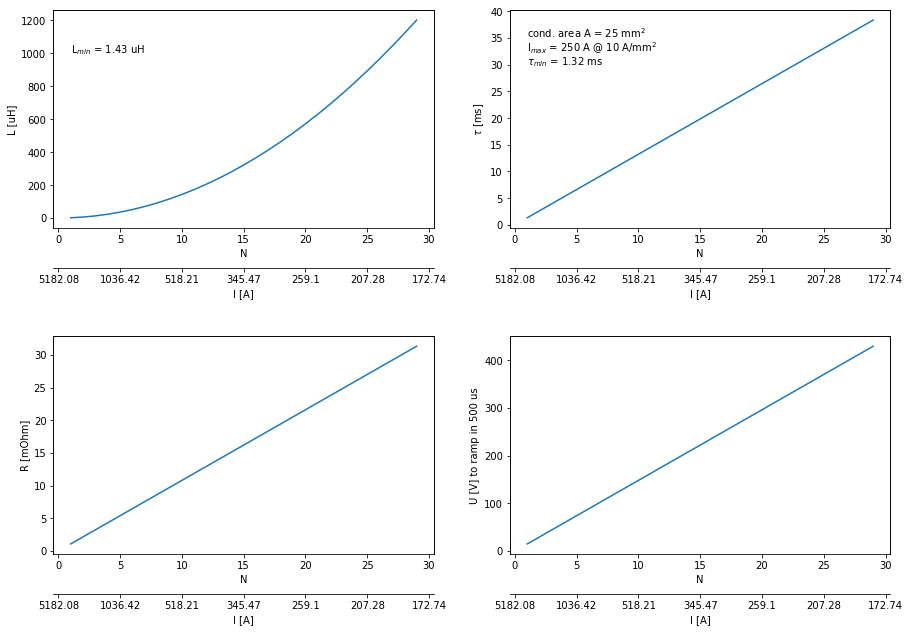

In [4]:
# induct. vs. turns vs. current

# turns
N_arr = np.arange(1,30)
I_arr = NI/N_arr

# inductance in uH
L_arr = u0*N_arr**2*hap/lgap*kick_l
# time constant in s
# resistance in copper
R = rho/A*l_wind*N_arr #25 mm2 cond. area
tau = L_arr/R

fig, axes = plt.subplots(2,2, figsize = (15,10))
plt.subplots_adjust(hspace = 0.5)

axes[0,0].plot(N_arr,L_arr*1e6)
axes[0,0].set_ylabel('L [uH]')
axes[0,0].set_xlabel('N')
axes[0,0].text(1,1000, r'L$_{{min}}$ = {} uH'.format(round(L_arr[0]*1e6,2)))

cplt.add_axis(axes[0,0], 'x', N_to_I, 'I [A]')

axes[0,1].plot(N_arr,tau*1e3)
axes[0,1].set_ylabel(r'$\tau$ [ms]')
axes[0,1].set_xlabel('N')
axes[0,1].text(1,35,r'cond. area A = {} mm$^2$'.format(A))
axes[0,1].text(1,32.5, r'I$_{{max}}$ = {} A @ 10 A/mm$^2$'.format(round(cdens*A),2))
axes[0,1].text(1,30, r'$\tau_{{min}}$ = {} ms'.format(round(tau[0]*1e3,2)))


cplt.add_axis(axes[0,1], 'x', N_to_I, 'I [A]')

axes[1,0].plot(N_arr, R*1e3)
axes[1,0].set_ylabel('R [mOhm]')
axes[1,0].set_xlabel('N')

cplt.add_axis(axes[1,0], 'x', N_to_I, 'I [A]')

# TODO: correct for U_total = LI' + RI
axes[1,1].plot(N_arr,L_arr*[N_to_I(x) for x in N_arr]/(500*1e-6))
axes[1,1].set_ylabel('U [V] to ramp in 500 us')
axes[1,1].set_xlabel('N')

cplt.add_axis(axes[1,1], 'x', N_to_I, 'I [A]')


plt.savefig('/home/marius/Jülich/Multiplexer/Plots/kickseptum_study')
plt.show()

### septum irradiation / gfr

In [98]:
# numeric integration of current fraction 
def num_gauss_int(a,b,dx_max,seq_dx,seq_int,sigma):
    d = {}

    for delta_x in np.linspace(0,dx_max,seq_dx):
        I = 0
        for step in np.linspace(a, b,seq_int):
            I += np.exp(-(step-delta_x)**2/(2*sigma**2))*np.abs(a-b)/seq_int

        I_norm = 1/(np.sqrt(2*np.pi)*sigma)*I

        d[delta_x] = I_norm
    
    return d

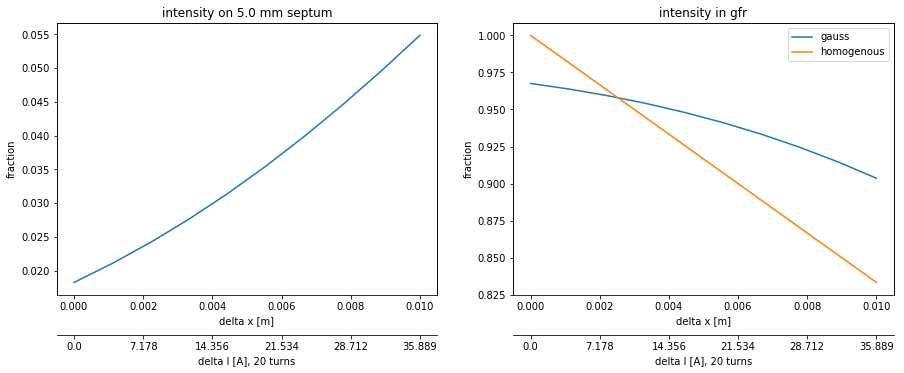

In [102]:

f_sep = num_gauss_int(2*sigma-w/2,2*sigma+w/2,delta_x_max,10,100,sigma)

f_gfr = num_gauss_int(-3*sigma, 2*sigma,delta_x_max,10,100,sigma)

fig, axes = plt.subplots(1,2, figsize = (15,5))

for i,dic in enumerate([f_sep,f_gfr]):

    ax = axes[i]
    ax.plot(*zip(*sorted(dic.items())))
    if i == 1:
        ax.plot(np.linspace(0,delta_x_max,10),1-np.linspace(0,delta_x_max,10)/(4*sigma))
        ax.legend(['gauss','homogenous'])
        
    ax.set_xlabel('delta x [m]')
    ax.set_ylabel('fraction')
    
    titles = ['on {} mm septum'.format(w*1e3), 'in gfr']
    ax.set_title('intensity ' + titles[i])

    #convert spat. to curr_off
    def dx_to_dI(dx):
        dThet = dx/l
        dI = brho*lgap/(u0*kick_l*N)*dThet
        return round(dI,3)

    cplt.add_axis(ax, 'x', dx_to_dI, 'delta I [A], {} turns'.format(N) )

plt.show()